In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [3]:
# Import Data
game_info = pd.read_parquet("../data/game_info.parquet")
game_tags = pd.read_parquet("../data/game_tags.parquet")
game_history = pd.read_parquet("../data/game_history.parquet")

# Data Preview

## Game Info

In [4]:
game_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8357 entries, 0 to 8356
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   title               8357 non-null   object        
 1   itad_uuid           8357 non-null   object        
 2   type                8002 non-null   category      
 3   achievements        8357 non-null   bool          
 4   mature              8357 non-null   bool          
 5   release_date        8048 non-null   datetime64[ns]
 6   rank                8357 non-null   int32         
 7   collected           8357 non-null   int32         
 8   steam_score         8357 non-null   int32         
 9   steam_review_count  8357 non-null   int32         
 10  has_release_date    8357 non-null   bool          
 11  review_tier         8357 non-null   category      
dtypes: bool(3), category(2), datetime64[ns](1), int32(4), object(2)
memory usage: 367.7+ KB


In [134]:
game_info.describe()

,release_date,rank,collected,steam_score,steam_review_count
count,8048,8357.000000,8357.000000,8357.000000,8.357000e+03
mean,2019-07-15 02:02:01.669980160,31997.028120,2480.050975,68.986837,5.224367e+03
min,1987-01-01 00:00:00,3.000000,0.000000,0.000000,1.000000e+00
25%,2016-10-25 00:00:00,11812.000000,130.000000,52.000000,6.600000e+01
50%,2020-01-28 12:00:00,27233.000000,883.000000,71.000000,1.590000e+02
75%,2023-04-10 06:00:00,48620.000000,2133.000000,89.000000,7.140000e+02
max,2025-12-31 00:00:00,84132.000000,80099.000000,100.000000,2.568074e+06
std,NaN,23686.762197,5523.017356,21.856002,4.933487e+04


In [29]:
game_info.steam_score.unique()

array([ 29,  51,  25,  26,  16,  27,  18,  34,  21,   0,  33,  19,  39,
         9,  20,  10,  13,  23,  22,  17,  50, 100,  24,  35,   5,  31,
        36,  15,  12,  30,   3,  14,  11,  80,   7,   2,  48,  47,  57,
        49,  58,  53,  43,  46,  40,  64,  44,  55,  38,  76,  41,  59,
        52,  68,  45,  56,  37,  60,  42,  67,  86,  85,  54,  63,  72,
        83,  70,  73,  69,  74,  65,  93,  75,  77,  32,  66,  79,  71,
        88,  62,  28,  89,  84,  90,  61,  94,  82,  81,  91,  78,  87,
        96,  92,  95,  97,  98,  99])

<Axes: >

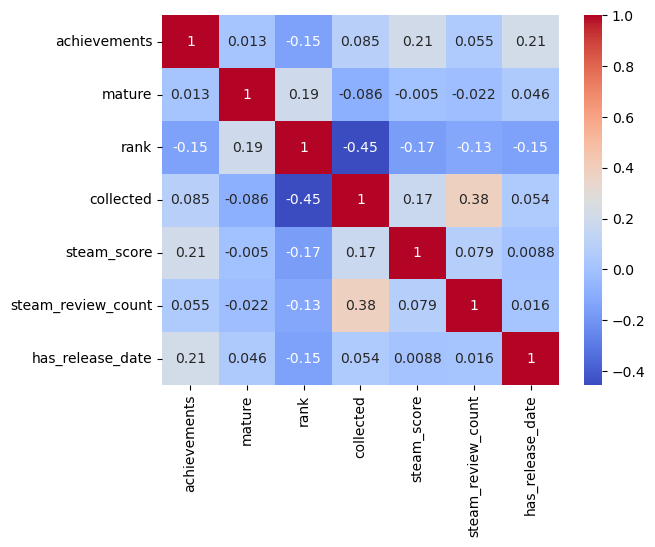

In [582]:
sns.heatmap(game_info.corr(numeric_only=True), annot=True, cmap="coolwarm")

Slightly highter correlation between `steam_review_count` and `collected`. This makes sense since people that actually own a game would be leaving reviews. you cant leave a review without owning the game. 

`collected` and `rank` is inversly correlated. This also makes sense since more people are likely to have a game of it is ranked better (closer to 1) as opposed to a worse rank (farther from 1)



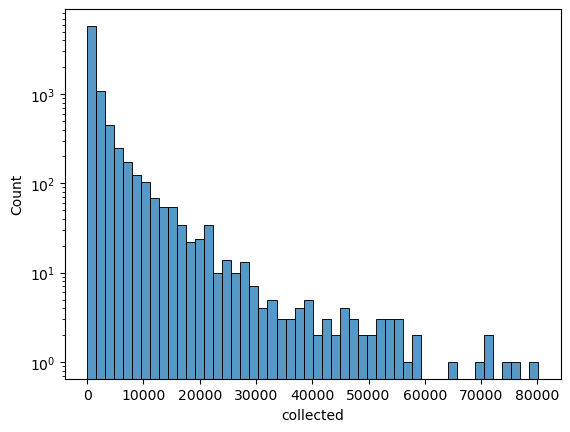

In [191]:
sns.histplot(game_info['collected'], bins=50)
plt.yscale('log')
plt.show()

## Is there a way to make mature games more successful?


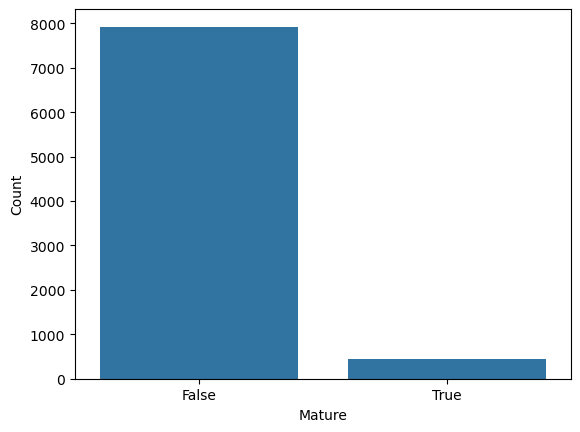

In [14]:
ax = sns.countplot(x="mature", data=game_info, order=[False, True])
ax.set_xlabel("Mature")
ax.set_ylabel("Count")
plt.show()

Data for Mature is skewed. There aren't as many `mature(NSFW)` games as `non-mature` games to begin with. In our entire dataset of 8357 rows, only 435 of them are `mature` (`5.2%`)

### Review Tier

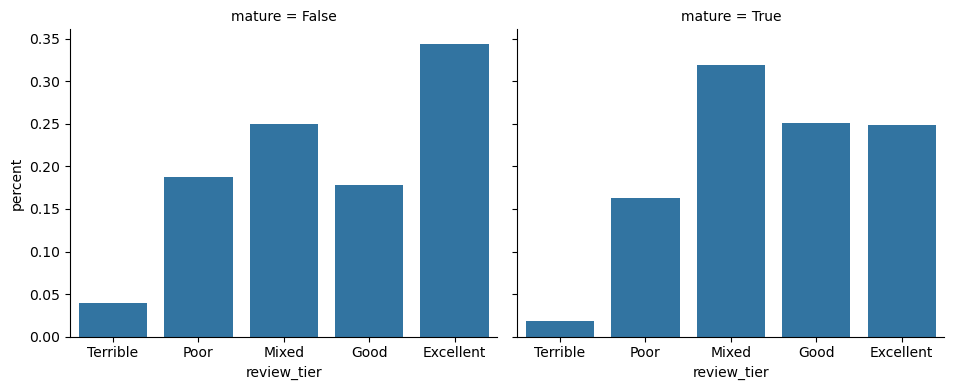

In [133]:
# ax = sns.countplot(x="review_tier", 
#                    data=game_info, 
#                    order=["Terrible", "Poor", "Mixed", "Good", "Excellent"])
# ax.set_xlabel("Review Tier")
# ax.set_ylabel("Count")
# plt.show()

plot_data = (
    pd.crosstab(game_info["mature"], game_info["review_tier"], normalize="index")
    .stack()
    .rename("percent")
    .reset_index()
)

sns.catplot(
    x="review_tier",
    y="percent",
    data=plot_data,
    kind="bar",
    col="mature",
    order=["Terrible", "Poor", "Mixed", "Good", "Excellent"],
    height=4,
    aspect=1.2
);


In [52]:
table = pd.crosstable(game_info['mature'], game_info['review_tier'])
chi2, p, dof, expected = chi2_contingency(table)
print("Chi-squared: ", chi2)
print("p-value: ", p)

Chi-squared:  36.9112266785902
p-value:  1.8787711953642405e-07


Given the chi-squared table, mature has nothing to do with the skewed data. So we can see that, percent-wise, mature games are less likely to be scored in the Excellent tier

Data Distribution:
- Excellent: 85–100
- Good: 70–84
- Mixed: 50–69
- Poor: 30–49
- Terrible: 1–29

This data is also a bit skewed. Probably mainly because I did not perfectly get a even distribution of data. Another reason is because steam reviews aren't centered on a true 50/50 "average". Reviewers are self-selected, as in they choose to buy/play, and people tend to avoid the harshest option. Titles that qualify as very negative/terrible are uncommon, so our sample contains much fewer of them. In other words, it's harder to get a bad tier, both because of human rating behavior and becausae fiew games sustain that level of negative feedback.

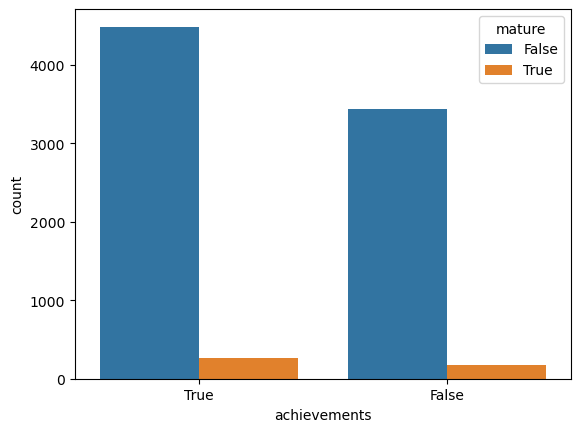

In [103]:
ax = sns.countplot(data=game_info, x='achievements', order=[True, False], hue='mature')

looks like achievements do not matter for mature games

## Does the month release matter?

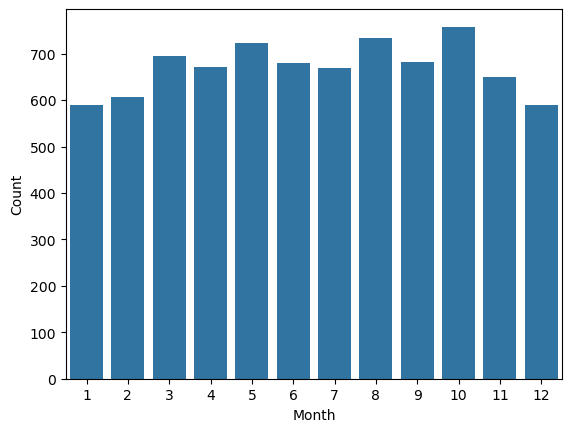

In [115]:
month_extract = game_info.query("has_release_date == True").copy()
month_extract['month'] = month_extract['release_date'].dt.month

ax = sns.countplot(x="month", data=month_extract)
ax.set_xlabel("Month")
ax.set_ylabel("Count")
plt.show()

The distribution of game releases per month are pretty much the same

<Axes: xlabel='month', ylabel='Proportion'>

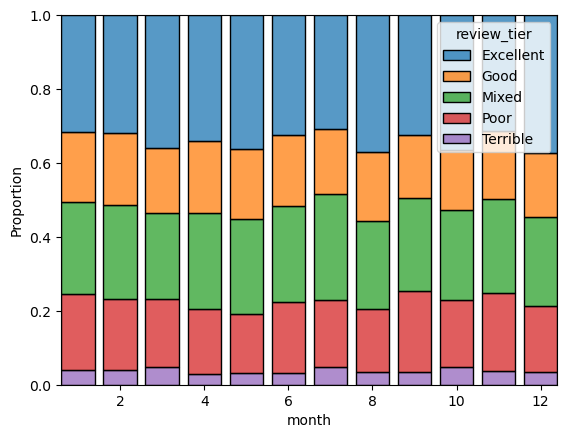

In [130]:
sns.histplot(
    data=month_extract,
    x='month', hue='review_tier',
    multiple='fill', stat='proportion',
    discrete=True, shrink=.8
)

### Steam review count

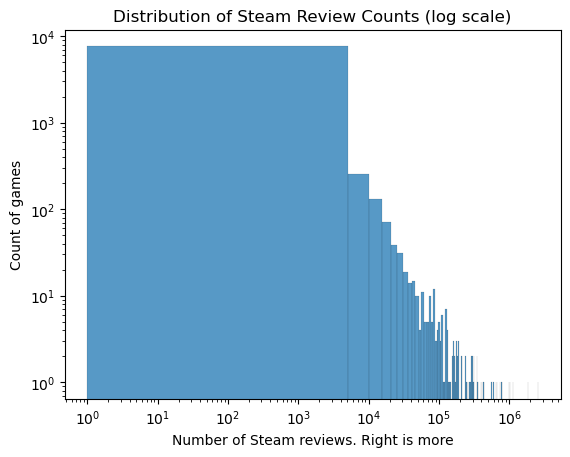

In [303]:
sns.histplot(game_info['steam_review_count'], bins=500)
plt.yscale('log')   # log scale on y-axis
plt.xscale('log')   # log scale on x-axis (optional)

plt.title("Distribution of Steam Review Counts (log scale)")
plt.xlabel("Number of Steam reviews. Right is more")
plt.ylabel("Count of games")

plt.show()

We see that there are a lot of games have less than 1000 reviews

## Game Tags

In [193]:
game_tags.describe()

,itad_uuid,title,tag
count,40571,40571,40571
unique,8353,8357,424
top,018d937e-f046-71c3-8bca-f9ee16f9fb99,Kerbal Space Program 2,Indie
freq,10,5,2600


In [40]:
game_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40571 entries, 0 to 40570
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   itad_uuid  40571 non-null  object
 1   title      40571 non-null  object
 2   tag        40571 non-null  object
dtypes: object(3)
memory usage: 951.0+ KB


In [218]:
game_tags.tag.unique()

array(['Space', 'Sandbox', 'Exploration', 'Building', 'Physics',
       'Free to Play', 'Card Battler', 'Trading Card Game',
       'Deckbuilding', 'PvP', 'Automobile Sim', 'Simulation', 'Driving',
       'Realistic', 'Casual', 'Racing', 'Indie', 'Sports', 'Adventure',
       'MMORPG', 'Nature', 'First-Person', 'Action', 'Horror',
       'City Builder', 'Strategy', 'RTS', 'Cold War', 'FPS',
       'Hack and Slash', 'RPG', 'Arcade', 'Co-op', 'Platformer',
       'Massively Multiplayer', 'Retro', 'Puzzle', 'Stealth', 'Heist',
       'Immersive Sim', 'Action-Adventure', 'Shooter', 'Sci-fi',
       'Singleplayer', 'Top-Down Shooter', 'Early Access',
       'Psychological Horror', 'Third-Person Shooter', 'Fighting', 'Loot',
       'Souls-like', 'Dark', 'Nudity', 'Hentai', 'Anime',
       'Sexual Content', 'On-Rails Shooter', 'Flight', 'Escape Room',
       'Online Co-Op', 'Atmospheric', 'Card Game', 'Visual Novel',
       'Zombies', 'Local Co-Op', 'Management', 'Character Customization',
  

### Top tags

In [260]:
def create_top_N(dataframe, col, N):
    s = dataframe[col].value_counts()
    out = s.iloc[:N]
    # out.loc['Other'] = s.iloc[N:].sum()
    df = out.reset_index()
    df.columns=['tag', 'count']
    return df

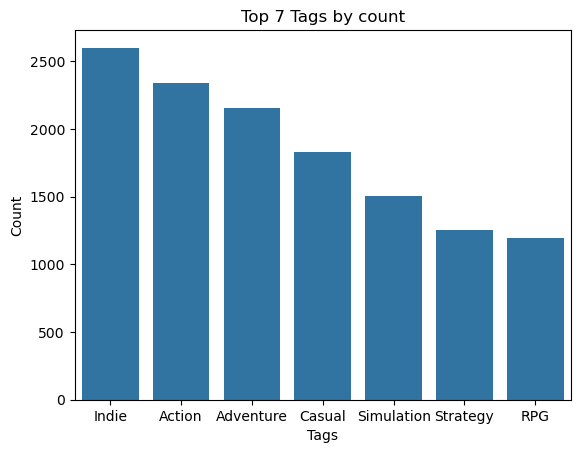

In [261]:
N = 7
df = create_top_N(game_tags, 'tag', N)

sns.barplot(df, x='tag', y='count')
plt.title(f"Top {N} Tags by count")
plt.xlabel("Tags")
plt.ylabel("Count")
plt.show();

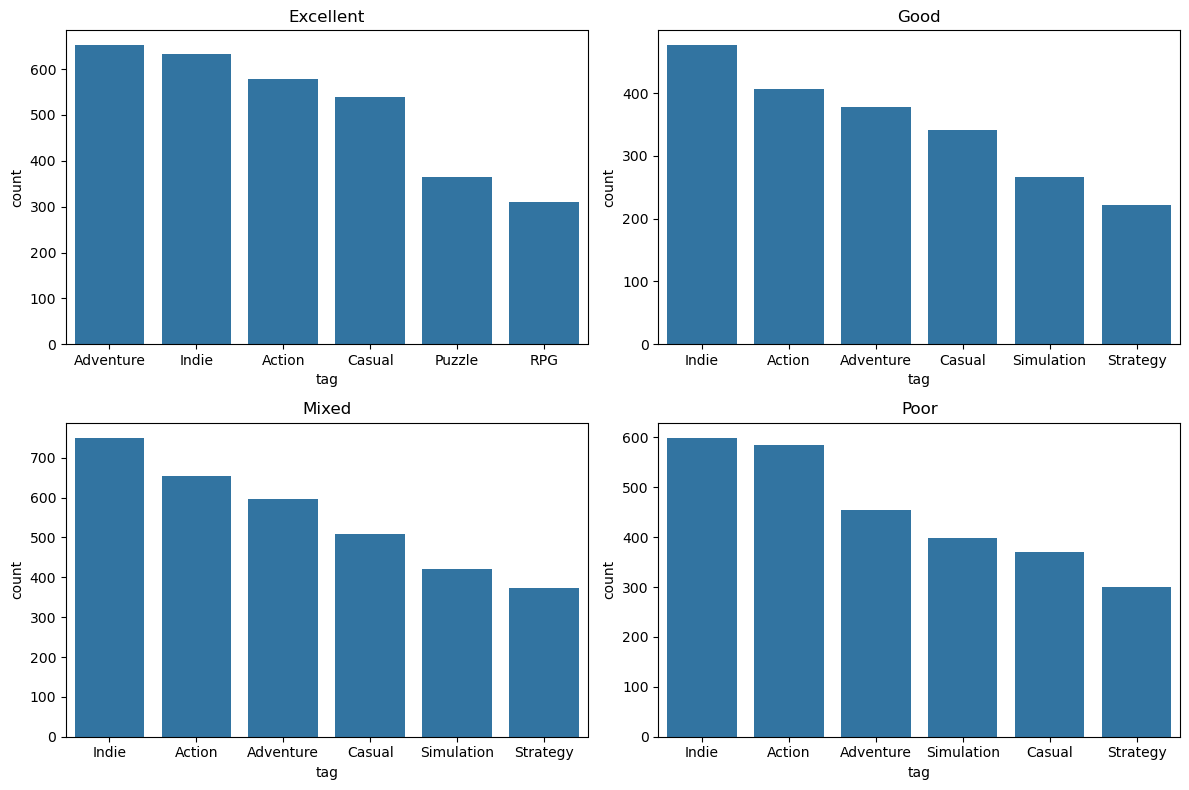

In [294]:
tags_with_tier = game_tags.merge(
    game_info[['itad_uuid', 'review_tier']],
    on='itad_uuid',
    how='left'
)
# tags_with_excellent = tags_with_tier.query("review_tier == 'Excellent'")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
N=6

df_excellent = create_top_N(tags_with_tier.query("review_tier == 'Excellent'"), "tag", N)
df_good = create_top_N(tags_with_tier.query("review_tier == 'Good'"), "tag", N)
df_mixed = create_top_N(tags_with_tier.query("review_tier == 'Mixed'"), "tag", N)
df_poor = create_top_N(tags_with_tier.query("review_tier == 'Poor'"), "tag", N)

sns.barplot(df_excellent, x='tag', y='count', ax=axes[0,0])
axes[0,0].set_title("Excellent")
sns.barplot(df_good, x='tag', y='count', ax=axes[0,1])
axes[0,1].set_title("Good")
sns.barplot(df_mixed, x='tag', y='count', ax=axes[1,0])
axes[1,0].set_title("Mixed")
sns.barplot(df_poor, x='tag', y='count', ax=axes[1,1])
axes[1,1].set_title("Poor")

plt.tight_layout()
plt.show();

`Indie`, `Action`, `Adventure`, `Casual` are in all 4 graphs, the rest of the vary but they are generally around the same place

We leave out the `Terrible` tier because there just isn't games in this tier

## Game History

In [194]:
game_history.describe()

,deal_price,regular_price,percent
count,463399.000000,463399.000000,463399.000000
mean,8.505232,12.002946,28.928010
std,9.976968,12.194353,32.977348
min,0.000000,0.000000,0.000000
25%,1.990000,4.990000,0.000000
50%,4.990000,9.990000,0.000000
75%,11.090000,14.990000,60.000000
max,999.000000,999.000000,120.000000


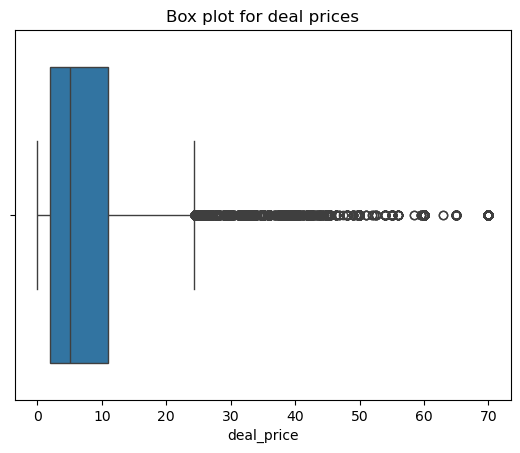

In [349]:
sns.boxplot(x=game_history['deal_price'])
plt.title("Box plot for deal prices")
plt.show();

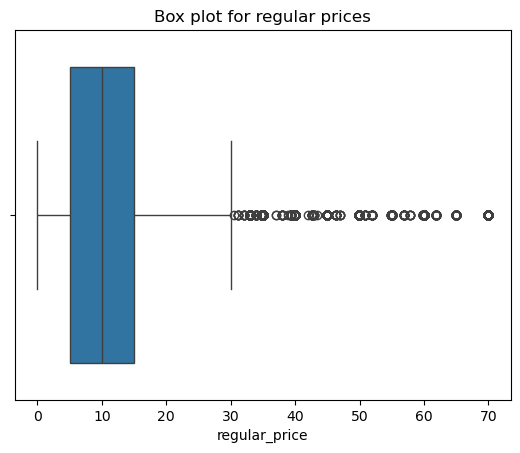

In [351]:
sns.boxplot(x=game_history['regular_price'])
plt.title("Box plot for regular prices")
plt.show();

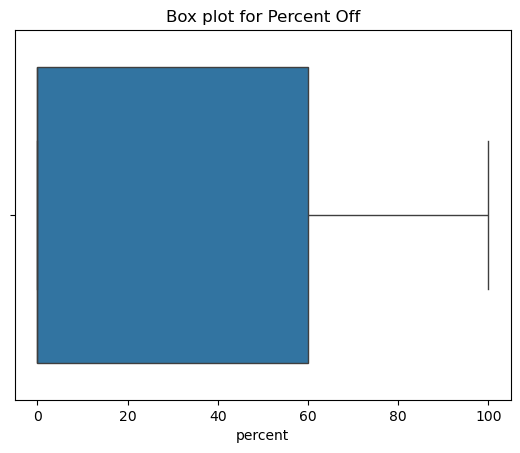

In [352]:
sns.boxplot(x=game_history['percent'])
plt.title("Box plot for Percent Off")
plt.show();

In [39]:
game_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463399 entries, 0 to 463398
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   itad_uuid      463399 non-null  object             
 1   timestamp      463399 non-null  datetime64[ns, UTC]
 2   deal_price     463399 non-null  float32            
 3   regular_price  463399 non-null  float32            
 4   percent        463399 non-null  uint8              
dtypes: datetime64[ns, UTC](1), float32(2), object(1), uint8(1)
memory usage: 11.0+ MB


In [353]:
game_history.describe()

,deal_price,regular_price,percent
count,462978.000000,462978.000000,462978.000000
mean,8.432707,11.857661,28.915905
std,9.234786,10.587730,32.962413
min,0.000000,0.000000,0.000000
25%,1.990000,4.990000,0.000000
50%,4.990000,9.990000,0.000000
75%,10.990000,14.990000,60.000000
max,69.989998,69.989998,100.000000


In [198]:
game_history.query('percent == 120')

,itad_uuid,timestamp,deal_price,regular_price,percent
111948,018d937e-f9d1-7389-a179-8a33cc54c261,2016-05-09 18:00:41+00:00,22.01,9.99,120


In [204]:
game_history.percent.unique()

array([  0,  40,  20,  50,  60,  55,  70,  65,  85,  33,  25,  30,  10,
        90,  75,  86,  80,  15,  67,  76,  35,  66,  24,  51,  83,  46,
        45,  37,  38,  62,  88,  72,  87,  68,  29,  14,  23,  77,  82,
        69,  74,  44,  71,  95,  89,  79,  78,  34,  48,  36,  49,  81,
        84,  64,  39,  43,  57,  91,  58, 100,   8,  54,  98,  99,  93,
        92,  97,  47,  17,  31,  52,  73,  61,  21,  27,  26,  56,  53,
        22,   4,   5,  16,   1,   7,  28,  32,  42,  41,  63,  13,  12,
        94,  11,  18,  59,  19,   2,   6,  96,   3,   9, 120], dtype=uint8)

In [211]:
game_history = game_history[game_history['percent'] <= 100]

In [337]:
game_history.query('deal_price > 70')

,itad_uuid,timestamp,deal_price,regular_price,percent
1326,018d937e-fa1a-70ed-9e5d-179c3ab1f53e,2014-09-17 04:30:18+00:00,199.990005,199.990005,0
5303,018d937f-35b7-7009-b85c-85b2cce4ef83,2019-04-13 01:40:39+00:00,499.000000,499.000000,0
16287,018d937f-1803-71b7-b3b7-3672f2801266,2025-06-08 17:18:55+00:00,120.000000,120.000000,0
16289,018d937f-1803-71b7-b3b7-3672f2801266,2025-04-25 17:15:46+00:00,120.000000,120.000000,0
16291,018d937f-1803-71b7-b3b7-3672f2801266,2025-03-20 17:47:40+00:00,120.000000,120.000000,0
...,...,...,...,...,...
414982,018d937f-013a-71f8-be61-b93626d4c5ac,2016-07-08 02:11:36+00:00,74.989998,74.989998,0
414984,018d937f-013a-71f8-be61-b93626d4c5ac,2016-07-07 11:39:18+00:00,74.989998,74.989998,0
416117,01955ccf-9813-73b5-b311-0fd8b0f317d3,2015-06-11 19:54:14+00:00,84.970001,84.970001,0
440700,018d937e-fa0b-7297-a4cf-67a04be88b4b,2015-03-02 18:27:07+00:00,99.989998,99.989998,0


In [354]:
# game_history = game_history[game_history['deal_price'] < 70]
# game_history = game_history[game_history['regular_price'] < 70]

In [355]:
# game_history.to_parquet('../data/game_history.parquet')

In [356]:
# game_history = pd.read_parquet("../data/game_history.parquet")

In [421]:
sale_occurances = game_history.query("percent > 0")

In [379]:
sale_occurances.percent.unique()

array([ 40,  20,  50,  60,  55,  70,  65,  85,  33,  25,  30,  10,  90,
        75,  86,  80,  15,  67,  76,  35,  66,  24,  51,  83,  46,  45,
        37,  38,  62,  88,  72,  87,  68,  29,  14,  23,  77,  82,  69,
        74,  44,  71,  95,  89,  79,  78,  34,  48,  36,  49,  81,  84,
        64,  39,  43,  57,  91,  58, 100,   8,  54,  92,  97,  47,  17,
        31,  99,  52,  73,  61,  21,  27,  26,  56,  53,  22,   4,   5,
        16,   1,   7,  28,  32,  42,  41,  63,  13,  12,  94,  11,  18,
        59,  19,   2,   6,  96,   3,   9,  98,  93], dtype=uint8)

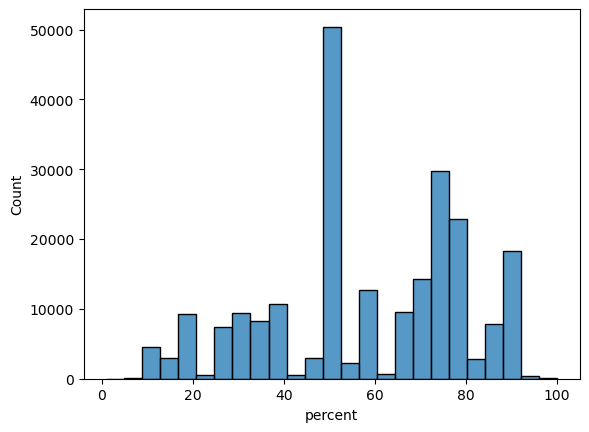

In [385]:
sns.histplot(data=sale_occurances, x='percent', bins=25);

There are a lot of games that are put on sale at 50% off. but the majority of games are 50 and above. games usually do not go on sale below 50. BUT this could mean that some games could be put on sale multiple times. We are tracking events here

In [432]:
min_discounts = (
    game_history.query("percent > 0")
    .groupby('itad_uuid')['percent']
    .min()
)
max_discounts = (
    game_history.query("percent > 0")
    .groupby('itad_uuid')['percent']
    .max()
)

itad_uuid
018d937e-e9ab-70f4-bd05-1db7a138eb39    50
018d937e-e9b0-7127-a7ba-b3ac7444befe    10
018d937e-e9b4-730e-bfaf-ed97c9a83c17    20
018d937e-e9b7-73a9-84e1-1546a164f911    10
018d937e-e9b7-73a9-84e1-1546a6abc89d    40
                                        ..
01981c63-43de-72f4-941b-97c0c1af7aa4    15
01984ec7-a768-72eb-ae8e-35493ee0eb0b    30
0198696b-c3be-705f-9762-03fad9bddcac    10
0198cc72-c3ad-738a-b51c-2c5e3a883380    10
0198e09e-0674-7308-8a87-9517a83596ff    10
Name: percent, Length: 6535, dtype: uint8


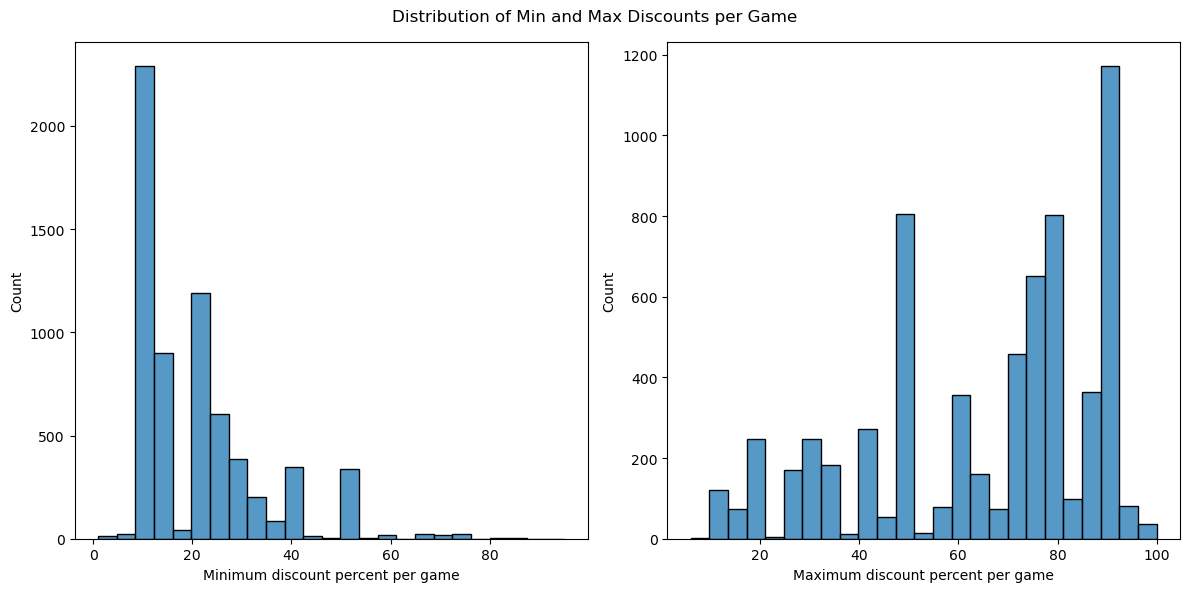

In [416]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(min_discounts, bins=25, ax=axes[0])
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Minimum discount percent per game")
sns.histplot(max_discounts, bins=25, ax=axes[1])
axes[1].set_ylabel("Count")
axes[1].set_xlabel("Maximum discount percent per game")

fig.suptitle("Distribution of Min and Max Discounts per Game")
plt.tight_layout()
plt.show()

Games typically start with small discounts (10-30%). Over time, most games eventually reach larger discounts, often around 80-90%. This suggests that discounts follow a lifecycle: small cuts at first, then larger reductions later.

### Month that games are put on sale

C:\Users\alext\AppData\Local\Temp\ipykernel_27096\1612103052.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sale_occurances['sale_month'] = sale_occurances['timestamp'].dt.month


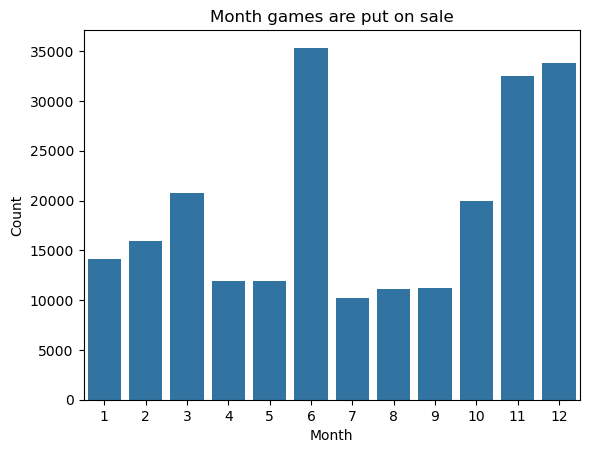

In [426]:
sale_occurances['sale_month'] = sale_occurances['timestamp'].dt.month
sns.countplot(data=sale_occurances, x='sale_month')
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Month games are put on sale")
plt.show();

Games are put on sale mainly around `June`, `November`, and `December`. This makes sense because `June` would be the beginning of Summer and `November`/`December` would be a holiday sale.

Not able to explain the slight spikes in `March` and `October` though

### Finding the average time it takes for when a game first goes on sale

In [506]:
first_discount = (
    game_history.query("percent > 0")
    .groupby("itad_uuid")["timestamp"]
    .min()
)

In [540]:
first_discount_merged = pd.merge(first_discount,
                                 game_info[["itad_uuid", "release_date","has_release_date","steam_score","review_tier"]],
                                 on="itad_uuid", 
                                 how="left")

In [541]:
first_discount_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6538 entries, 0 to 6537
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   itad_uuid         6538 non-null   object             
 1   timestamp         6538 non-null   datetime64[ns, UTC]
 2   release_date      6305 non-null   datetime64[ns]     
 3   has_release_date  6483 non-null   object             
 4   steam_score       6483 non-null   float64            
 5   review_tier       6483 non-null   category           
dtypes: category(1), datetime64[ns, UTC](1), datetime64[ns](1), float64(1), object(2)
memory usage: 262.1+ KB


In [542]:
first_discount_notnull = first_discount_merged.query("has_release_date == True").copy()
first_discount_notnull['timestamp'] = first_discount_notnull['timestamp'].dt.tz_localize(None)

In [543]:
first_discount_notnull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6305 entries, 0 to 6537
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   itad_uuid         6305 non-null   object        
 1   timestamp         6305 non-null   datetime64[ns]
 2   release_date      6305 non-null   datetime64[ns]
 3   has_release_date  6305 non-null   object        
 4   steam_score       6305 non-null   float64       
 5   review_tier       6305 non-null   category      
dtypes: category(1), datetime64[ns](2), float64(1), object(2)
memory usage: 301.9+ KB


In [544]:
first_discount_notnull['first_sale_days'] = (first_discount_notnull['timestamp']- first_discount_notnull['release_date']).dt.total_seconds()/86400

In [545]:
first_discount_notnull['first_sale_days'] = first_discount_notnull['first_sale_days'].astype('float64')

In [546]:
first_discount_notnull.query("first_sale_days < 0 ")

,itad_uuid,timestamp,release_date,has_release_date,steam_score,review_tier,first_sale_days
14,018d937e-e9c7-7383-948e-7b73b0541acb,2016-12-23 00:45:40,2021-11-01,True,89.0,Excellent,-1773.968287
30,018d937e-e9e1-727e-b14e-450ffd40165f,2012-10-16 17:03:07,2019-08-30,True,96.0,Excellent,-2508.289502
36,018d937e-e9e6-7060-9895-152b5ad55a6a,2016-08-24 10:45:28,2016-10-10,True,43.0,Poor,-46.551759
45,018d937e-e9f3-736d-b2b8-02f0e5850ede,2013-11-27 18:21:59,2015-04-02,True,85.0,Excellent,-490.234734
62,018d937e-ea04-70ff-ba76-70273de6e582,2018-09-27 17:29:50,2019-07-10,True,23.0,Terrible,-285.270949
...,...,...,...,...,...,...,...
6495,01968657-fcbf-7069-b8b7-50c18f808b2d,2024-06-18 09:18:19,2024-12-11,True,85.0,Excellent,-175.612280
6510,01970d1e-8c3d-73d3-93b8-5b174816b6ca,2025-06-12 22:14:02,2025-06-13,True,100.0,Excellent,-0.073588
6512,0197198e-5adc-724c-9c3f-680ee10dbc57,2025-07-22 23:45:26,2025-07-23,True,75.0,Good,-0.010116
6517,01974521-b1ff-7315-8ea0-d5faa8449f69,2025-06-08 19:19:46,2025-07-15,True,45.0,Poor,-36.194606


In [547]:
first_discount_notnull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6305 entries, 0 to 6537
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   itad_uuid         6305 non-null   object        
 1   timestamp         6305 non-null   datetime64[ns]
 2   release_date      6305 non-null   datetime64[ns]
 3   has_release_date  6305 non-null   object        
 4   steam_score       6305 non-null   float64       
 5   review_tier       6305 non-null   category      
 6   first_sale_days   6305 non-null   float64       
dtypes: category(1), datetime64[ns](2), float64(2), object(2)
memory usage: 351.2+ KB


In [548]:
first_discount_notnull.describe()

,timestamp,release_date,steam_score,first_sale_days
count,6305,6305,6305.000000,6305.000000
mean,2019-07-02 23:39:18.101982464,2018-12-21 00:32:12.180808704,69.184615,193.963263
min,2012-09-04 19:43:12,1987-01-01 00:00:00,0.000000,-3814.331042
25%,2016-06-23 19:27:21,2016-05-04 00:00:00,53.000000,0.505035
50%,2019-05-09 22:17:23,2019-04-11 00:00:00,71.000000,0.906539
75%,2022-11-14 17:41:46,2022-10-19 00:00:00,89.000000,66.810949
max,2025-09-10 14:48:24,2025-09-12 00:00:00,100.000000,12171.660324
std,NaN,NaN,21.903859,900.579421


In [551]:
pos_first_discount = first_discount_notnull.query("first_sale_days >= 0 ")

In [552]:
pos_first_discount.describe()

,timestamp,release_date,steam_score,first_sale_days
count,5522,5522,5522.000000,5522.000000
mean,2019-08-01 07:32:13.700108544,2018-10-29 15:17:08.757696512,69.484426,275.677141
min,2012-09-04 19:43:12,1987-01-01 00:00:00,0.000000,0.000150
25%,2016-07-29 18:17:20.500000,2016-03-25 00:00:00,53.000000,0.668773
50%,2019-06-25 23:29:22.500000,2019-02-27 00:00:00,72.000000,1.280920
75%,2022-12-31 07:09:31.500000,2022-10-14 00:00:00,90.000000,85.584488
max,2025-09-10 14:48:24,2025-09-10 00:00:00,100.000000,12171.660324
std,NaN,NaN,21.904244,913.054614


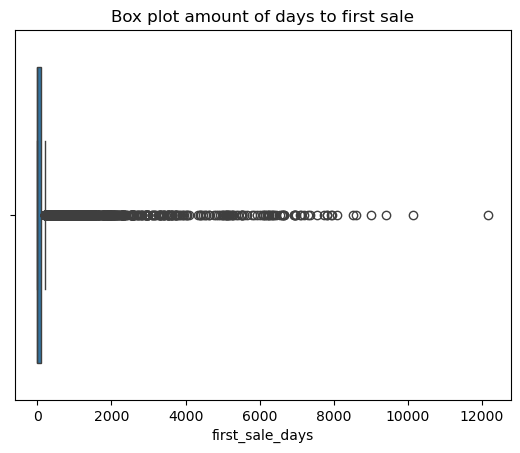

In [553]:
sns.boxplot(x=pos_first_discount['first_sale_days'])
plt.title("Box plot amount of days to first sale")
plt.show();

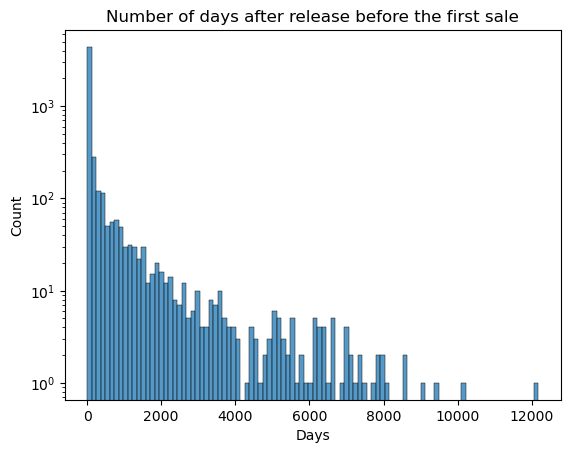

In [569]:
sns.histplot(data=pos_first_discount, x='first_sale_days', bins=100)
plt.yscale("log")
plt.xlabel("Days")
plt.title("Number of days after release before the first sale")
plt.show()

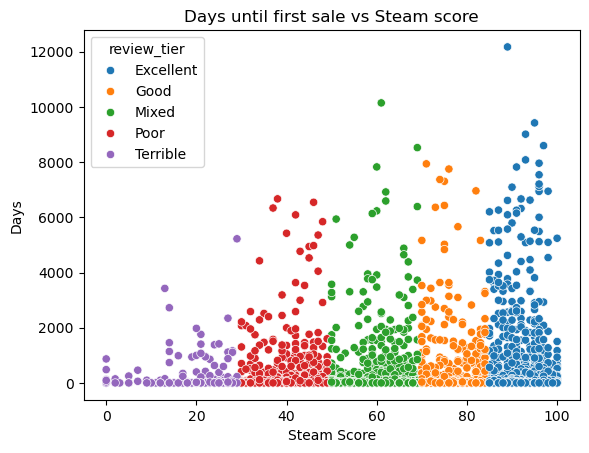

In [575]:
sns.scatterplot(data=pos_first_discount, y='first_sale_days', x="steam_score", hue='review_tier')
plt.title("Days until first sale vs Steam score")
plt.ylabel("Days")
plt.xlabel("Steam Score")
plt.show()

Games that are higher in tier tend to more LATER first sale dates. but still a majority of games 

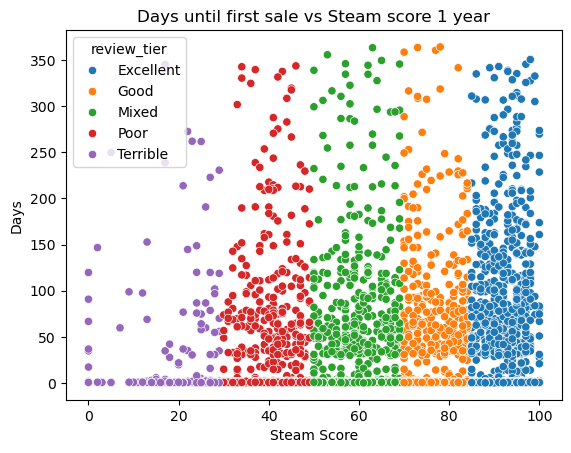

In [581]:
first_discount_clipped = pos_first_discount.query("first_sale_days <=365")
sns.scatterplot(data=first_discount_clipped, y='first_sale_days', x="steam_score", hue='review_tier')
plt.title("Days until first sale vs Steam score 1 year")
plt.ylabel("Days")
plt.xlabel("Steam Score")
plt.show()

### 